### Processing outliers
high values are caped to reduce the effect of outliers.

This notebook tests different approaches on how to handle outliers:\
(For each counter separately:) The Q1 and Q3 quantiles and IQR are calculated, and then all data points above the threshold (Q3 + adjustable_constant * IQR) are capped and set to exactly this threshold value. The different approaches below differ in which data points are included in the calculation of the threshold for a given data point.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read in data

In [ ]:
# Read in "cleaned_full_data.csv"
data_cleaned = pd.read_csv("../data/cleaned_full_data.csv")
data_cleaned['timestamp'] = pd.to_datetime(data_cleaned['timestamp'], utc = True, errors='coerce') 
data_cleaned.head()

C:\Users\kraus\AppData\Local\Temp\ipykernel_9436\2816930178.py:2: DtypeWarning: Columns (5,6,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_cleaned = pd.read_csv("../data/cleaned_full_data.csv")


city counter_site_name  counter_site_id  longitude   latitude  \
0  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   
1  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   
2  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   
3  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   
4  Stadt Karlsruhe  Erbprinzenstraße        100004165   8.402715  49.007286   

  channels_in channels_out channels_unknown  count site_temperature  \
0           9           10               na     19              5.0   
1          15           18               na     33              5.0   
2          17           14               na     31              5.0   
3          14           26               na     40              5.0   
4          13           17               na     30              5.0   

  site_rain_accumulation site_snow_accumulation                 timestamp  
0                    0.0                     na 2012-12-31 23:00:00+00:00  
1                    0.0                     na 2013-01-01 00:00:00+00:00  
2                    0.0                     na 2013-01-01 01:00:00+00:00  
3                    0.0                     na 2013-01-01 02:00:00+00:00  
4                    0.0                     na 2013-01-01 03:00:00+00:00

In [ ]:
# for testing: only consider the first 30 counter_site_id
unique_counters = data_cleaned['counter_site_id'].unique()[:30]
data_cleaned = data_cleaned[data_cleaned['counter_site_id'].isin(unique_counters)]

In [4]:
# Get unique counters and their cities (needed for plotting)
counters_info = data_cleaned[['counter_site_id', 'city']].drop_duplicates()
num_counters = len(counters_info)

## Approach 1:
Quantiles are calculated over all data points of the counter.

Advantages: Very simple and we can be very conservative here.

Disadvantage: For counters with a strong trend (e.g., Counter 1000034894 in Stuttgart), the threshold is too high for early years and too low for later years. Therefore, Approach 2 is definitely better than Approach 1, as it has the same advantages without this major disadvantage.

In [ ]:
# Function: set all values above  Q3 + cap_const ·IQR to exactly Q3 + cap_const·IQR (for each counter seperately)
def cap_counter(counter_data, values_where="count", cap_const=5):
    Q1 = counter_data[values_where].quantile(0.25)
    Q3 = counter_data[values_where].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + cap_const * IQR
    
    # Save which values were capped
    counter_data[f'{values_where}_capped'] = counter_data[values_where] > upper_bound

    counter_data[values_where] = np.where(
        counter_data[values_where] > upper_bound, 
        upper_bound, 
        counter_data[values_where]
    )
    return counter_data

def cap_outliers(data, values_where="count", cap_const=5):
    return data.groupby('counter_site_id', group_keys=False).apply(cap_counter, values_where=values_where, cap_const=cap_const)

In [ ]:
# Cap high counter values
cap_const = 6
data_cap = cap_outliers(data_cleaned, "count", cap_const=cap_const) 
# contain column 'count_capped' indicating whether the value was capped and column 'count' with the capped values

#data_cap.head()

C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\3886453284.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('counter_site_id', group_keys=False).apply(cap_counter, values_where=values_where, cap_const=cap_const)


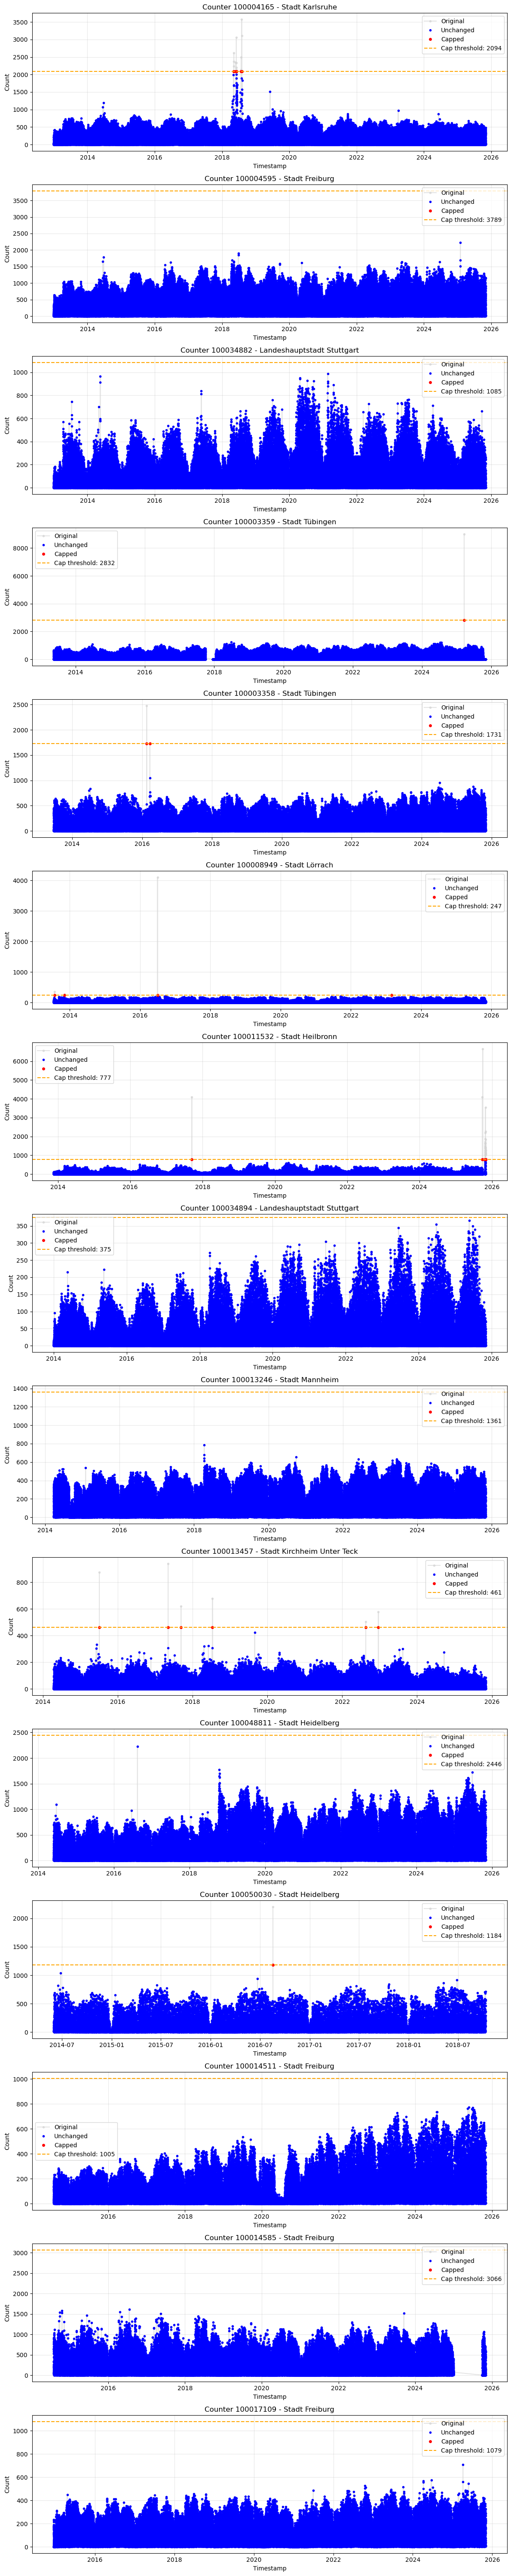

In [7]:
# Plotting the results for each counter
fig, axes = plt.subplots(num_counters, 1, figsize=(12, 4*num_counters))

# Ensure axes is iterable even for single subplot
if num_counters == 1:
    axes = [axes]

for idx, (_, counter_info) in enumerate(counters_info.iterrows()):
    counter_id = counter_info['counter_site_id']
    city = counter_info['city']
    
    # Filter data for this counter
    counter_data_cap = data_cap[data_cap['counter_site_id'] == counter_id].sort_values('timestamp')
    counter_data_clean = data_cleaned[data_cleaned['counter_site_id'] == counter_id].sort_values('timestamp')
    
    # Calculate upper bound for this counter
    Q3 = counter_data_clean['count'].quantile(0.75)
    Q1 = counter_data_clean['count'].quantile(0.25)
    IQR = Q3 - Q1
    upper_bound = Q3 + cap_const * IQR
    
    ax = axes[idx]
    
    # Plot original data (cleaned) in gray
    ax.plot(counter_data_clean['timestamp'], counter_data_clean['count'], 
            'o-', color='lightgray', alpha=0.6, label='Original', markersize=3)
    
    # Plot capped data - different colors for capped vs not capped
    capped_mask = counter_data_cap['count_capped']
    ax.plot(counter_data_cap[~capped_mask]['timestamp'], 
            counter_data_cap[~capped_mask]['count'], 
            'o', color='blue', label='Unchanged', markersize=3)
    ax.plot(counter_data_cap[capped_mask]['timestamp'], 
            counter_data_cap[capped_mask]['count'], 
            'o', color='red', label='Capped', markersize=4)
    
    # Add horizontal line for cap threshold
    ax.axhline(y=upper_bound, linestyle='--', color='orange', 
               label=f'Cap threshold: {upper_bound:.0f}')
    
    ax.set_title(f"Counter {counter_id} - {city}")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Approach 2:
Data is grouped by year, and then quantiles are calculated separately for each year over all data points of that year.

Advantage: Simple and allows us to remove only extremely high outliers without changing the rest of the data. It roughly accounts for the trend, so that's no longer a problem.

Disadvantage: Does not account for seasonal or daily fluctuations / the fact that seasonalities exist in the data that already create strong variability. A value is compared to all other data points regardless of, e.g., time of day. It is normal that, for example, at noon the value is much higher than at night and is not necessarily an outlier. The threshold is therefore relatively low for data points during peak hours and too high for, say, nighttime hours. However, perhaps we want to tolerate high values at night/in winter because we know from summer times/afternoons that it's possible for that many bicycles to pass through.

In [8]:
#  Function: Cap the outliers by calculating the thresholds in yearly intervals, to account for the trend

# set all median values above Q3 + cap_const·IQR to exactly Q3 + cap_const·IQR (for each counter and year separately)
def cap_counter_by_year(counter_data, values_where="count", cap_const=5):
    # Extract year from timestamp
    counter_data['year'] = counter_data['timestamp'].dt.year
    
    # Calculate bounds for each year
    for year in counter_data['year'].unique():
        year_mask = counter_data['year'] == year
        year_data = counter_data.loc[year_mask, values_where]
        
        Q1 = year_data.quantile(0.25)
        Q3 = year_data.quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + cap_const * IQR
        
        # Mark which values were capped for this year
        counter_data.loc[year_mask, f'{values_where}_capped'] = year_data > upper_bound
        
        # Cap values for this year
        counter_data.loc[year_mask, values_where] = np.where(
            year_data > upper_bound, 
            upper_bound, 
            year_data
        )
    
    counter_data.drop('year', axis=1, inplace=True)
    return counter_data

def cap_outliers_by_year(data, values_where="count", cap_const=5):
    return data.groupby('counter_site_id', group_keys=False).apply(
        cap_counter_by_year, values_where=values_where, cap_const=cap_const
    )

In [9]:
# Cap high values with yearly threshold
cap_const_yearly = 3
data_cap_yearly = cap_outliers_by_year(data_cleaned, "count", cap_const=cap_const_yearly) 
#enthält Spalte 'count_capped' die angibt ob der Wert gecappt wurde und Spalte 'count' mit den gecappten Werten

#data_cap.head()

C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\903917758.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[13. 19. 20. ... 25. 11. 19.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  counter_data.loc[year_mask, values_where] = np.where(
C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\903917758.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('counter_site_id', group_keys=False).apply(


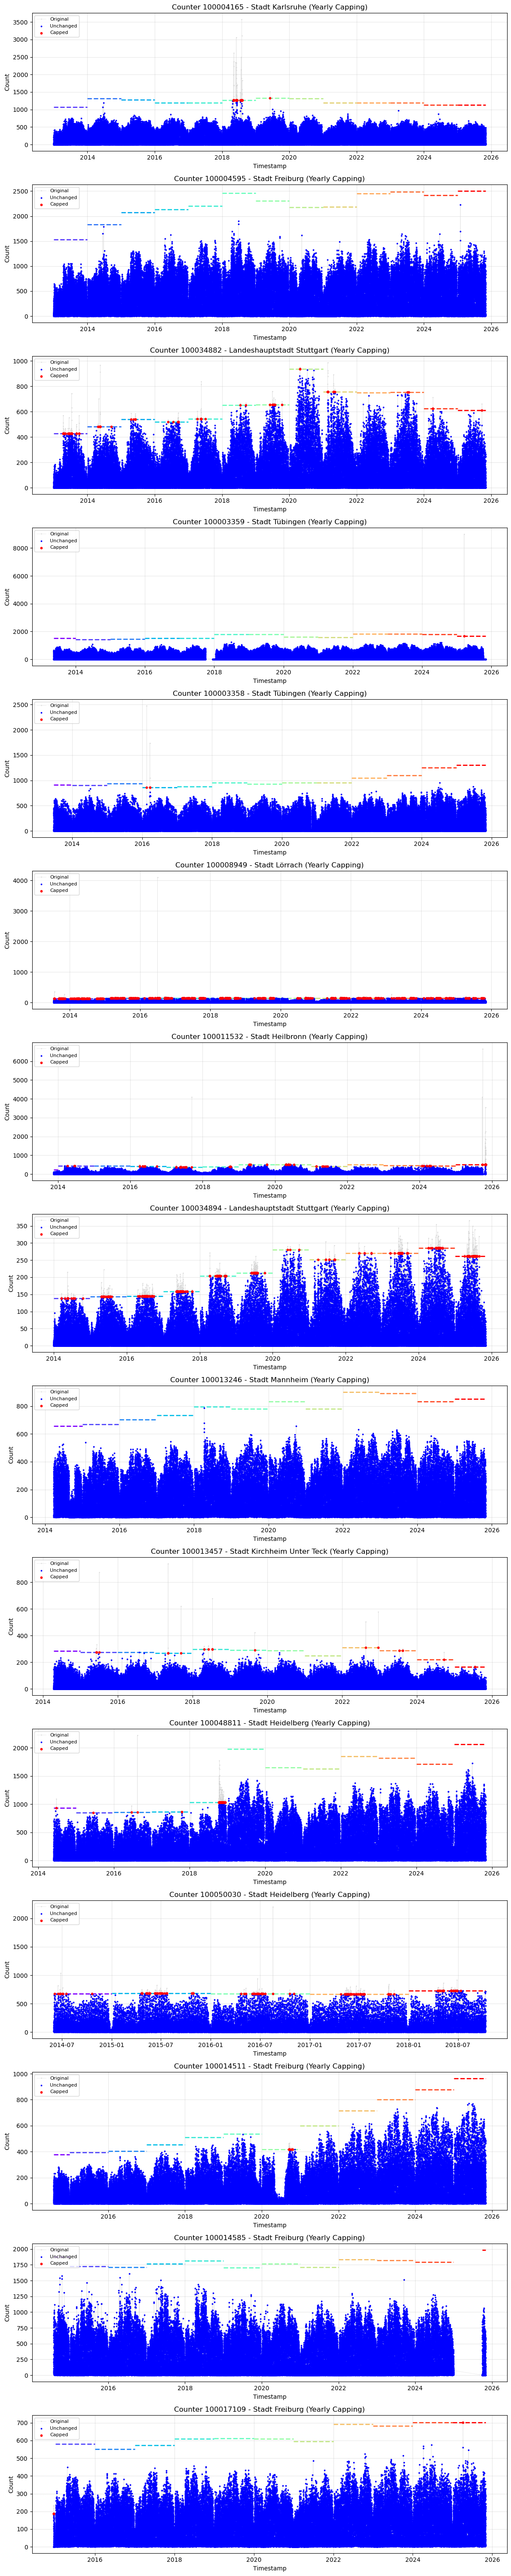

In [10]:
# Plot the yearly capped data with yearly thresholds
fig, axes = plt.subplots(num_counters, 1, figsize=(12, 4*num_counters))

# Ensure axes is iterable even for single subplot
if num_counters == 1:
    axes = [axes]

for idx, (_, counter_info) in enumerate(counters_info.iterrows()):
    counter_id = counter_info['counter_site_id']
    city = counter_info['city']
    
    # Filter data for this counter
    counter_data_cap_yearly = data_cap_yearly[data_cap_yearly['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    counter_data_clean = data_cleaned[data_cleaned['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    
    ax = axes[idx]
    
    # Plot original data (cleaned) in gray
    ax.plot(counter_data_clean['timestamp'], counter_data_clean['count'], 
            'o-', color='lightgray', alpha=0.6, label='Original', markersize=1, linewidth=0.5)
    
    # Calculate and plot yearly thresholds
    counter_data_clean['year'] = counter_data_clean['timestamp'].dt.year
    years = sorted(counter_data_clean['year'].unique())
    
    colors = plt.cm.rainbow(np.linspace(0, 1, len(years)))
    
    for year_idx, year in enumerate(years):
        year_mask = counter_data_clean['year'] == year
        year_data = counter_data_clean[year_mask]
        
        Q1 = year_data['count'].quantile(0.25)
        Q3 = year_data['count'].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + cap_const_yearly * IQR
        
        # Plot horizontal line for this year's threshold
        year_start = year_data['timestamp'].min()
        year_end = year_data['timestamp'].max()
        ax.hlines(y=upper_bound, xmin=year_start, xmax=year_end, 
                 linestyle='--', color=colors[year_idx], linewidth=2)
    
    # Plot capped and unchanged data
    capped_mask = counter_data_cap_yearly['count_capped'].astype(bool)
    
    ax.scatter(counter_data_cap_yearly[~capped_mask]['timestamp'], 
               counter_data_cap_yearly[~capped_mask]['count'], 
               color='blue', label='Unchanged', s=3, zorder=4)
    ax.scatter(counter_data_cap_yearly[capped_mask]['timestamp'], 
               counter_data_cap_yearly[capped_mask]['count'], 
               color='red', label='Capped', s=10, zorder=5)
    
    ax.set_title(f"Counter {counter_id} - {city} (Yearly Capping)")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Approach 3:
Quantiles/thresholds are calculated separately for each hour of the day.

Advantages: Accounts for daily fluctuations. Runs significantly faster than if we also consider seasonal variations. The quantiles are probably more stable because they are calculated over many more data points.

Disadvantages: Does not account for seasonal fluctuations. The expected values are actually quite heavily influenced by seasonal variations.

In [11]:
# Function: Cap outliers based on hour-of-day patterns
def cap_counter_by_hour(counter_data, values_where="count", cap_const=5):
    counter_data = counter_data.copy()
    
    # Extract hour from timestamp
    counter_data['hour'] = counter_data['timestamp'].dt.hour
    
    # Calculate bounds for each hour
    for hour in counter_data['hour'].unique():
        hour_mask = counter_data['hour'] == hour
        hour_data = counter_data.loc[hour_mask, values_where]
        
        Q1 = hour_data.quantile(0.25)
        Q3 = hour_data.quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + cap_const * IQR
        
        # Mark which values were capped for this hour
        counter_data.loc[hour_mask, f'{values_where}_capped'] = hour_data > upper_bound
        
        # Cap values for this hour
        counter_data.loc[hour_mask, values_where] = np.where(
            hour_data > upper_bound, 
            upper_bound, 
            hour_data
        )
    
    counter_data.drop('hour', axis=1, inplace=True)
    return counter_data

def cap_outliers_by_hour(data, values_where="count", cap_const=5):
    return data.groupby('counter_site_id', group_keys=False).apply(
        cap_counter_by_hour, values_where=values_where, cap_const=cap_const
    )

In [12]:
# Cap high counter values based on hour-of-day pattern
cap_const_hour = 5
data_cap_hour = cap_outliers_by_hour(data_cleaned, "count", cap_const=cap_const_hour)

C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\2387016694.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 20.  36.  32. ... 103. 102.  87.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  counter_data.loc[hour_mask, values_where] = np.where(
C:\Users\kraus\AppData\Local\Temp\ipykernel_33848\2387016694.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('counter_site_id', group_keys=False).apply(


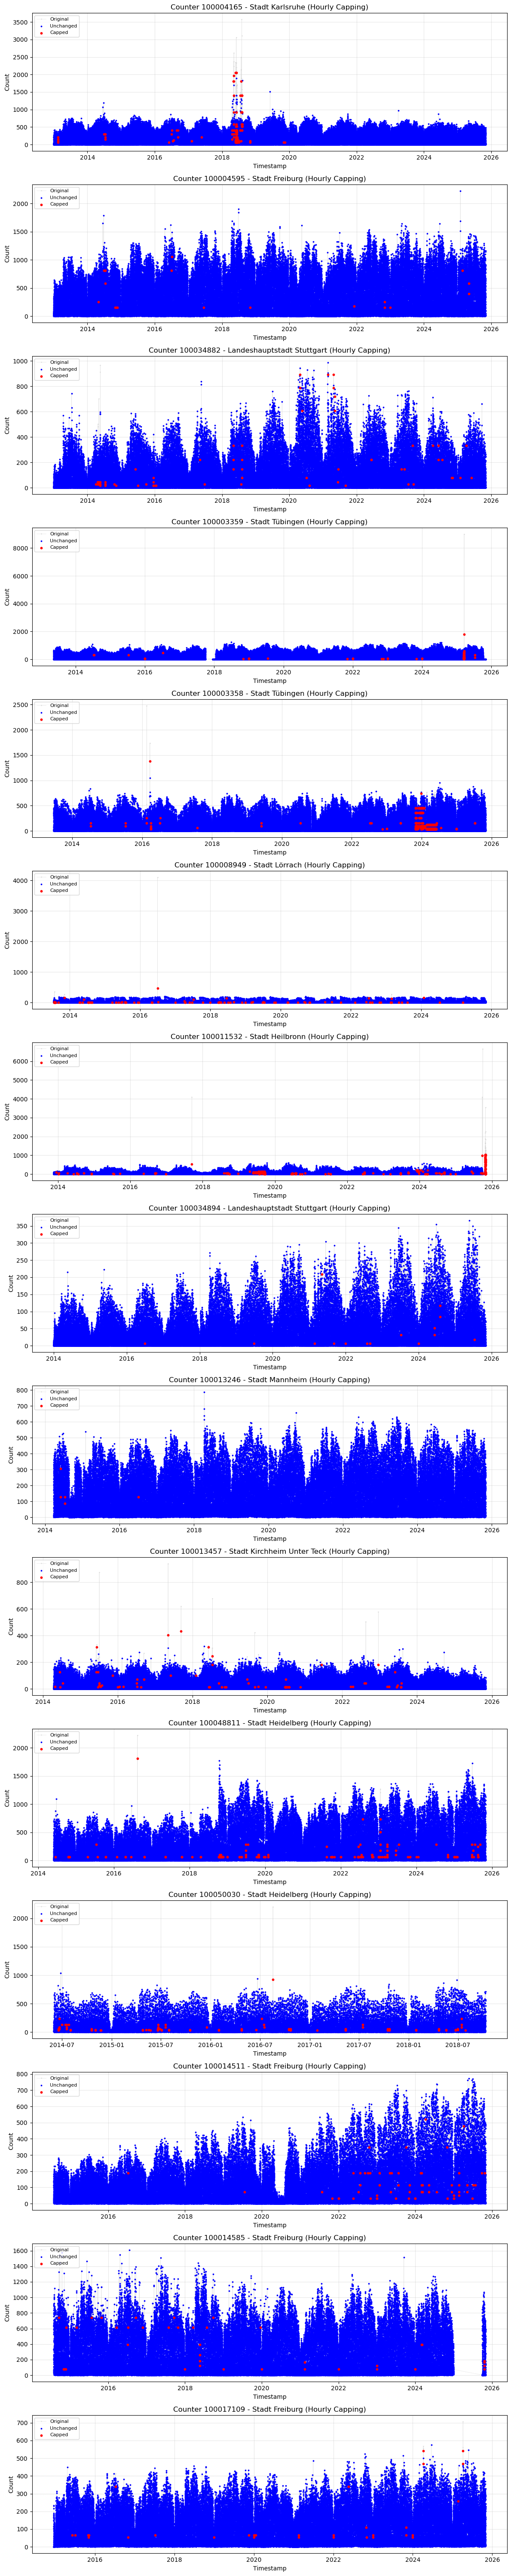

In [13]:
# Plot the hourly capped data
fig, axes = plt.subplots(num_counters, 1, figsize=(12, 4*num_counters))
# Ensure axes is iterable even for single subplot
if num_counters == 1:
    axes = [axes]
for idx, (_, counter_info) in enumerate(counters_info.iterrows()):
    
    counter_id = counter_info['counter_site_id']
    city = counter_info['city']
    
    # Filter data for this counter
    counter_data_cap_hour = data_cap_hour[data_cap_hour['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    counter_data_clean = data_cleaned[data_cleaned['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    
    ax = axes[idx]
    
    # Plot original data (cleaned) in gray
    ax.plot(counter_data_clean['timestamp'], counter_data_clean['count'], 
            'o-', color='lightgray', alpha=0.6, label='Original', markersize=1, linewidth=0.5)
    
    # Plot capped and unchanged data
    capped_mask = counter_data_cap_hour['count_capped'].astype(bool)
    
    ax.scatter(counter_data_cap_hour[~capped_mask]['timestamp'], 
               counter_data_cap_hour[~capped_mask]['count'], 
               color='blue', label='Unchanged', s=3, zorder=4)
    ax.scatter(counter_data_cap_hour[capped_mask]['timestamp'], 
               counter_data_cap_hour[capped_mask]['count'], 
               color='red', label='Capped', s=10, zorder=5)
    
    ax.set_title(f"Counter {counter_id} - {city} (Hourly Capping)")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Approach 4:

Quantiles/thresholds are calculated separately for each hour-of-day and day-of-year combination.

Advantages: Accounts for both seasonal and daily fluctuations. Extremely high outliers are filtered out quite well, but also many values that appear to be too high for the time of day or year but are not so high compared to other times. Do we want that?

Disadvantages: Takes a very long time to calculate. Does not necessarily account for the trend.

In [5]:
# Function: Cap outliers based on hour-of-day and day-of-year patterns (quantiles and IQR calculated for each hour and day_of_year combination)
def cap_counter_by_time_pattern(counter_data, values_where="count", cap_const=5):
    counter_data = counter_data.copy()
    
    # Extract time features
    counter_data['hour'] = counter_data['timestamp'].dt.hour
    counter_data['day_of_year'] = counter_data['timestamp'].dt.dayofyear

    # Convert to float to avoid dtype mismatch
    counter_data[values_where] = counter_data[values_where].astype(float)
    
    # Initialize capped column
    counter_data[f'{values_where}_capped'] = False
    
    # Group by hour and day_of_year and calculate IQR for each group
    for (hour, day_of_year), group_indices in counter_data.groupby(['hour', 'day_of_year']).groups.items():
        group_data = counter_data.loc[group_indices, values_where]
        
        if len(group_data) > 3:  # Need at least 4 points for meaningful quartiles
            Q1 = group_data.quantile(0.25)
            if Q1 == 0: # skip capping if Q1 is 0
                continue
            Q3 = group_data.quantile(0.75)
            IQR = Q3 - Q1
            upper_bound = Q3 + cap_const * IQR
            
            # Mark and cap outliers
            outlier_mask = group_data > upper_bound
            counter_data.loc[group_indices[outlier_mask], f'{values_where}_capped'] = True
            counter_data.loc[group_indices[outlier_mask], values_where] = upper_bound
    
    counter_data.drop(['hour', 'day_of_year'], axis=1, inplace=True)
    return counter_data

def cap_outliers_by_time_pattern(data, values_where="count", cap_const=5):
    return data.groupby('counter_site_id', group_keys=False).apply(
        cap_counter_by_time_pattern, values_where=values_where, cap_const=cap_const
    )

In [6]:
# Cap high counter values based on hour-of-day and day-of-year patterns
cap_const_pattern = 9
data_cap_pattern = cap_outliers_by_time_pattern(data_cleaned, "count", cap_const=cap_const_pattern)

C:\Users\kraus\AppData\Local\Temp\ipykernel_9436\3680521151.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('counter_site_id', group_keys=False).apply(


In [ ]:
# information über data_cap_pattern printen
print(data_cap_pattern.head())
print(data_cap_pattern.info())

In [ ]:
#information über ursprüngliche Daten
print(data_cleaned.head())
print(data_cleaned.info())

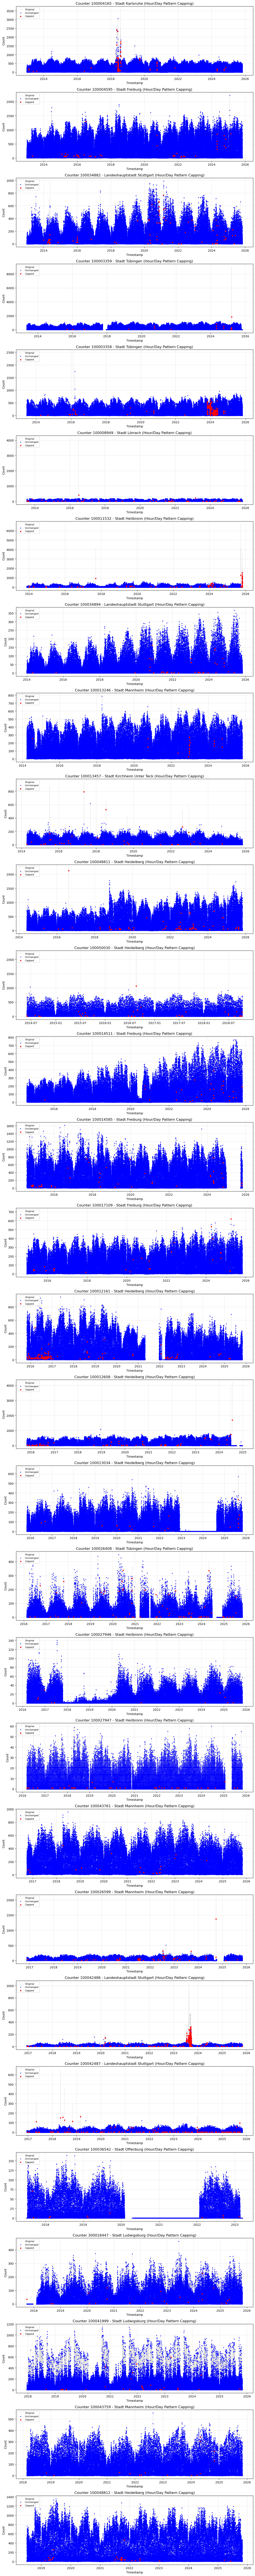

In [26]:
# Plot the pattern-based capped data
fig, axes = plt.subplots(num_counters, 1, figsize=(12, 4*num_counters))

# Ensure axes is iterable even for single subplot
if num_counters == 1:
    axes = [axes]

for idx, (_, counter_info) in enumerate(counters_info.iterrows()):
    counter_id = counter_info['counter_site_id']
    city = counter_info['city']
    
    # Filter data for this counter
    counter_data_cap_pattern = data_cap_pattern[data_cap_pattern['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    counter_data_clean = data_cleaned[data_cleaned['counter_site_id'] == counter_id].sort_values('timestamp').reset_index(drop=True)
    
    ax = axes[idx]
    
    # Plot original data (cleaned) in gray
    ax.plot(counter_data_clean['timestamp'], counter_data_clean['count'], 
            'o-', color='lightgray', alpha=0.8, label='Original', markersize=1, linewidth=0.5)
    
    # Plot capped and unchanged data
    capped_mask = counter_data_cap_pattern['count_capped'].astype(bool)
    
    ax.scatter(counter_data_cap_pattern[~capped_mask]['timestamp'], 
               counter_data_cap_pattern[~capped_mask]['count'], 
               color='blue', label='Unchanged', s=3, zorder=4)
    ax.scatter(counter_data_cap_pattern[capped_mask]['timestamp'], 
               counter_data_cap_pattern[capped_mask]['count'], 
               color='red', label='Capped', s=10, zorder=5)
    
    ax.set_title(f"Counter {counter_id} - {city} (Hour/Day Pattern Capping)")
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Count')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()